<a href="https://colab.research.google.com/github/PalmChalan/AI-Engineering-Coursework/blob/main/CNN_Dog-Breed-Classification.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import random
import torch
import torch.nn.functional as F
import numpy as np
import cv2
import pickle
from matplotlib import pyplot as plt
from torchvision.datasets import ImageFolder
from scipy.spatial.distance import cdist

# 1.Pixel as feature on CIFAR-10 Dataset

The CIFAR-10 dataset consists of 60000 32x32 colour images in 10 classes. The 10 different classes represent airplanes, cars, birds, cats, deer, dogs, frogs, horses, ships, and trucks. There are 6,000 images of each class. Here are the  10 random images from class:
![CIFAR-10 samples image](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/cifar-10-samples.png)

In [ ]:
### CIFAR-10 dataset helper function ###

'''
data -- a 10000x3072 numpy array of uint8s. Each row of the array stores a 32x32 colour image. The first 1024 entries contain the red channel values, the next 1024 the green, and the final 1024 the blue. The image is stored in row-major order, so that the first 32 entries of the array are the red channel values of the first row of the image.
labels -- a list of 10000 numbers in the range 0-9. The number at index i indicates the label of the ith image in the array data.
'''
def unpickle(file):
    with open(file, 'rb') as fo:
        dict = pickle.load(fo, encoding='bytes')
    return dict

def cifar10Loader(setName='train', datasetDir='cifar-10-batches-py/'):
  cifarImages = []
  cifarLabels = []

  if setName == 'train':
    fileNamePrefix = 'data_batch_'
    for batchNo in range(1,6):
      batchData = unpickle(datasetDir + fileNamePrefix + str(batchNo))
      cifarImages.append(batchData[b'data'])
      cifarLabels.append(batchData[b'labels'])
    cifarImages = np.concatenate(cifarImages)
    cifarLabels = np.concatenate(cifarLabels)
    return cifarImages, cifarLabels

  else:
    batchData = unpickle(datasetDir + 'test_batch')
    return batchData[b'data'], batchData[b'labels']

def cifar10Labels(datasetDir='cifar-10-batches-py/'):
  byteLabels = unpickle(datasetDir + 'batches.meta')[b'label_names']
  return [label.decode("utf-8")  for label in byteLabels]

## 1.1 Download and Inspect CIFAR-10 dataset

In [ ]:
### Download and Extract CIFAR-10 Dataset ###
!wget -O cifar-10-python.tar.gz https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
!tar xf cifar-10-python.tar.gz

--2021-11-11 10:29:39--  https://www.cs.toronto.edu/~kriz/cifar-10-python.tar.gz
Resolving www.cs.toronto.edu (www.cs.toronto.edu)... 128.100.3.30
Connecting to www.cs.toronto.edu (www.cs.toronto.edu)|128.100.3.30|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 170498071 (163M) [application/x-gzip]
Saving to: ‘cifar-10-python.tar.gz’

cifar-10-python.tar 100%[===================>] 162.60M  89.3MB/s    in 1.8s    

2021-11-11 10:29:41 (89.3 MB/s) - ‘cifar-10-python.tar.gz’ saved [170498071/170498071]



In [ ]:
cifarTrainImages, cifarTrainLabels = cifar10Loader(setName='train')
cifarTestImages, cifarTestLabels = cifar10Loader(setName='test')
cifarLabelNames = cifar10Labels()

cifarTrainImages = cifarTrainImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
cifarTestImages = cifarTestImages.reshape(-1, 3, 32, 32).transpose(0,2,3,1)
totalTrainImages = len(cifarTrainLabels)
totalTestImages = len(cifarTestLabels)

print('Total train images :', totalTrainImages)
print('Total test images :', totalTestImages)
print('Labels :',cifarLabelNames)
print('cifarTrainImages shape :', cifarTrainImages.shape)
print('cifarTestImages shape :', cifarTestImages.shape)

Total train images : 50000
Total test images : 10000
Labels : ['airplane', 'automobile', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck']
cifarTrainImages shape : (50000, 32, 32, 3)
cifarTestImages shape : (10000, 32, 32, 3)


['bird', 'horse', 'automobile', 'cat', 'automobile', 'airplane', 'ship', 'automobile']


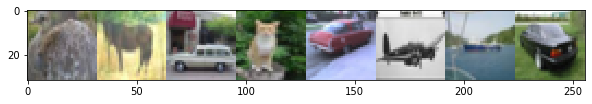

In [ ]:
### Randomly show train images and their labels ###
randTrainIdx = random.sample(range(0, totalTrainImages), 8)
sampleTrainImages = np.concatenate([cifarTrainImages[idx, :] for idx in randTrainIdx],axis=1)

plt.figure(figsize=(10,10))
plt.imshow(sampleTrainImages, interpolation='nearest')
print([ cifarLabelNames[labelIdx] for labelIdx in cifarTrainLabels[randTrainIdx]])

## 1.2 CIFAR-10 classification using nearest neighbour


Sample image real label => horse  Nearest label in train set => horse


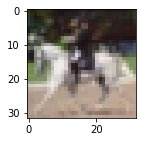

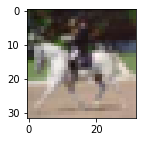

In [ ]:
### Randomly pick a image from test set ###
randTestIdx = random.randint(0, totalTestImages)
sampleTestImages = cifarTestImages[randTestIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(sampleTestImages, interpolation='nearest')

### Find a nearest image from train set using euclidean distance ###
distance = ((sampleTestImages - cifarTrainImages)**2).reshape(totalTrainImages,-1)
distance = np.sqrt(np.sum(distance,axis=1))
minDistance = np.min(distance)
minIdx = np.argmin(distance)

nearestTrainImage = cifarTrainImages[minIdx, :]

plt.figure(figsize=(2,2))
plt.imshow(nearestTrainImage, interpolation='nearest')
print('Sample image real label =>', cifarLabelNames[cifarTestLabels[randTestIdx]],' Nearest label in train set =>', cifarLabelNames[cifarTrainLabels[minIdx]])

#### The output result will be very bad ==> pixel as feature is not enough ###

# 2.Convolutional Neural Networks Building Block
![alt text](http://cs231n.github.io/assets/cnn/convnet.jpeg)
Image from CS231n Convolutional Neural Networks for Visual Recognition [CS231n Convolutional Neural Networks for Visual Recognition](http://cs231n.github.io/convolutional-networks/)

## 2.1 Convolution Layer

In [ ]:
%%html
<iframe src="https://cs231n.github.io/assets/conv-demo/index.html" width="800" height="700"></iframe>

## 2.2 Pooling Layer
<br>
<img src="http://cs231n.github.io/assets/cnn/pool.jpeg" width="36%">
<img src="http://cs231n.github.io/assets/cnn/maxpool.jpeg" width="59%">

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder

## 2.3 Get familiar with PyTorch layers

In [ ]:
### Convolution & MaxPool operators in PyTorch ###
sampleInput = torch.tensor([[[[1,2,3,4],[5,6,7,8],[9,10,11,12],[13,14,15,16]]]],dtype=torch.float32)
print(sampleInput)

print('=== Convolution ===')
kernel = torch.tensor([[[[1,1],[1,1]]]], dtype=torch.float32)
convOutput = F.conv2d(sampleInput, kernel, padding=0)
print(convOutput, convOutput.shape)

print('=== Maxpool ===')
maxPoolOutput = F.max_pool2d(sampleInput, kernel_size=2)
print(maxPoolOutput)

tensor([[[[ 1.,  2.,  3.,  4.],
          [ 5.,  6.,  7.,  8.],
          [ 9., 10., 11., 12.],
          [13., 14., 15., 16.]]]])
=== Convolution ===
tensor([[[[14., 18., 22.],
          [30., 34., 38.],
          [46., 50., 54.]]]]) torch.Size([1, 1, 3, 3])
=== Maxpool ===
tensor([[[[ 6.,  8.],
          [14., 16.]]]])


/usr/local/lib/python3.7/dist-packages/torch/nn/functional.py:718: UserWarning: Named tensors and all their associated APIs are an experimental feature and subject to change. Please do not use them for anything important until they are released as stable. (Triggered internally at  /pytorch/c10/core/TensorImpl.h:1156.)
  return torch.max_pool2d(input, kernel_size, stride, padding, dilation, ceil_mode)


# 3.Example CNN real world usage : Fastener Classification

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

## 3.1 GPU status check

In [ ]:
!nvidia-smi

Thu Nov 11 10:29:47 2021       
+-----------------------------------------------------------------------------+
| NVIDIA-SMI 495.44       Driver Version: 460.32.03    CUDA Version: 11.2     |
|-------------------------------+----------------------+----------------------+
| GPU  Name        Persistence-M| Bus-Id        Disp.A | Volatile Uncorr. ECC |
| Fan  Temp  Perf  Pwr:Usage/Cap|         Memory-Usage | GPU-Util  Compute M. |
|                               |                      |               MIG M. |
|===============================+======================+======================|
|   0  Tesla K80           Off  | 00000000:00:04.0 Off |                    0 |
| N/A   46C    P8    30W / 149W |      0MiB / 11441MiB |      0%      Default |
|                               |                      |                  N/A |
+-------------------------------+----------------------+----------------------+
                                                                               
+-------

## 3.2 Download and inspect train fastener dataset
You can download the dataset to your computer from [here](https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip)

In [ ]:
### Download fastener dataset ###
!wget  -O fastenerDataset.zip https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip
!unzip -qo fastenerDataset.zip

--2021-11-11 10:29:47--  https://github.com/Chula-PIC-Lab/AI4Engineer/raw/master/fastenerDataset.zip
Resolving github.com (github.com)... 140.82.113.3
Connecting to github.com (github.com)|140.82.113.3|:443... connected.
HTTP request sent, awaiting response... 302 Found
Location: https://raw.githubusercontent.com/Chula-PIC-Lab/AI4Engineer/master/fastenerDataset.zip [following]
--2021-11-11 10:29:47--  https://raw.githubusercontent.com/Chula-PIC-Lab/AI4Engineer/master/fastenerDataset.zip
Resolving raw.githubusercontent.com (raw.githubusercontent.com)... 185.199.108.133, 185.199.109.133, 185.199.110.133, ...
Connecting to raw.githubusercontent.com (raw.githubusercontent.com)|185.199.108.133|:443... connected.
HTTP request sent, awaiting response... 200 OK
Length: 31247894 (30M) [application/zip]
Saving to: ‘fastenerDataset.zip’

fastenerDataset.zip 100%[===================>]  29.80M   128MB/s    in 0.2s    

2021-11-11 10:29:48 (128 MB/s) - ‘fastenerDataset.zip’ saved [31247894/31247894]

In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

In [ ]:
### Dataloader for our dataset ###
transform = transforms.Compose([transforms.Resize((224,224)), transforms.ToTensor(), transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])])
fastenerTrainDataset = ImageFolder('fastenerDataset/train/', transform=transform)
fastenerTestDataset = ImageFolder('fastenerDataset/test/', transform=transform)

print('Total train set images :', len(fastenerTrainDataset))
print('Total test set images :', len(fastenerTestDataset))

Total train set images : 1132
Total test set images : 435


## 3.3 Fastener dataset visualization

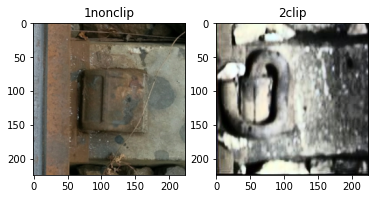

image size (224, 224, 3)


In [ ]:
nonClipImage, nonClipClassName = getImageFromDataset(fastenerTrainDataset, 4)
clipExistImage, clipExistClassName = getImageFromDataset(fastenerTrainDataset, 700)

_, figure = plt.subplots(1,2)

figure[0].imshow(nonClipImage)
figure[0].title.set_text(nonClipClassName)

figure[1].imshow(clipExistImage)
figure[1].title.set_text(clipExistClassName)
plt.show()

print('image size', nonClipImage.shape)

## 3.4 Define simple CNN network for fastener classification based on VGG-8.
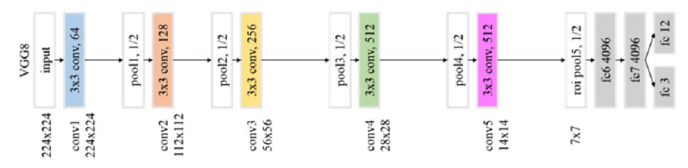


In [ ]:
### Build simple CNN ###
class simpleFastenerNet(nn.Module):
  def __init__(self):
    super(simpleFastenerNet, self).__init__()
    self.conv1 = nn.Conv2d(3, 64, kernel_size=3, stride=1, padding=1)
    self.pool1 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv2 = nn.Conv2d(64, 128, kernel_size=3, padding=1)
    self.pool2 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv3 = nn.Conv2d(128, 256, kernel_size=3, padding=1)
    self.pool3 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.conv4 = nn.Conv2d(256, 512, kernel_size=3, padding=1)
    self.pool4 = nn.MaxPool2d(kernel_size=2, stride=2)


    self.conv5 = nn.Conv2d(512, 512, kernel_size=3, padding=1)
    self.pool5 = nn.MaxPool2d(kernel_size=2, stride=2)

    self.fc6 = nn.Linear(512*7*7, 4096)
    self.fc7 = nn.Linear(4096, 2)


  def forward(self, input): # 1 x 3 x 224 x 224
    x = self.pool1(F.relu(self.conv1(input)))
    x = self.pool2(F.relu(self.conv2(x)))
    x = self.pool3(F.relu(self.conv3(x)))
    x = self.pool4(F.relu(self.conv4(x)))
    x = self.pool5(F.relu(self.conv5(x))) # 512x7x7


    x = x.view(-1, 512*7*7)

    x = F.relu(self.fc6(x))
    x = self.fc7(x)
    return x


## 3.5 Construct the model, optimizer and loss function

In [ ]:
net = simpleFastenerNet()
net.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


## 3.6 Train the model

In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader,
                                                                    net,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=10)

Overall Training Progress::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

## 3.7 Find the confusion matrix and calculate TP, TN, FP, and FN

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

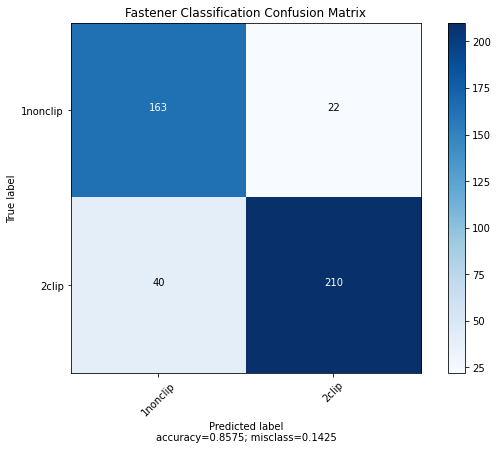

TP:163 TN:22 FP:40 FN:210


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

In [ ]:
#### Calculcate  Specificity, Sensitivity ###
sensitivity = tp / (tp+fn)
specificity = tn / (fp+tn)

## 3.8 Show Classification Results

In [ ]:
def showRandomSamples(labels, predicted, testDataset, sampleNum=5):
  equals = labels == predicted
  correctIdx = np.where(equals == 1)[0].tolist()
  incorrectIdx = np.where(equals == 0)[0].tolist()

  randomCorrectIdx = random.sample(correctIdx, sampleNum)
  randomIncorrectIdx  = random.sample(incorrectIdx, sampleNum)

  _, figure = plt.subplots(2,sampleNum,figsize=(30,10))

  ### Plot Correct ###
  for imageIdx in range(len(randomCorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomCorrectIdx[imageIdx])
    figure[0,imageIdx].imshow(image,cmap='gray')
    figure[0,imageIdx].title.set_text('[CORRECT] '+className)

  for imageIdx in range(len(randomIncorrectIdx)):
    image, className = getImageFromDataset(testDataset, randomIncorrectIdx[imageIdx])
    figure[1,imageIdx].imshow(image,cmap='gray')
    predictedClassName = testDataset.classes[predicted[randomIncorrectIdx[imageIdx]]]
    figure[1,imageIdx].title.set_text('Actual:'+className+' Predicted:' + predictedClassName)

  plt.show()

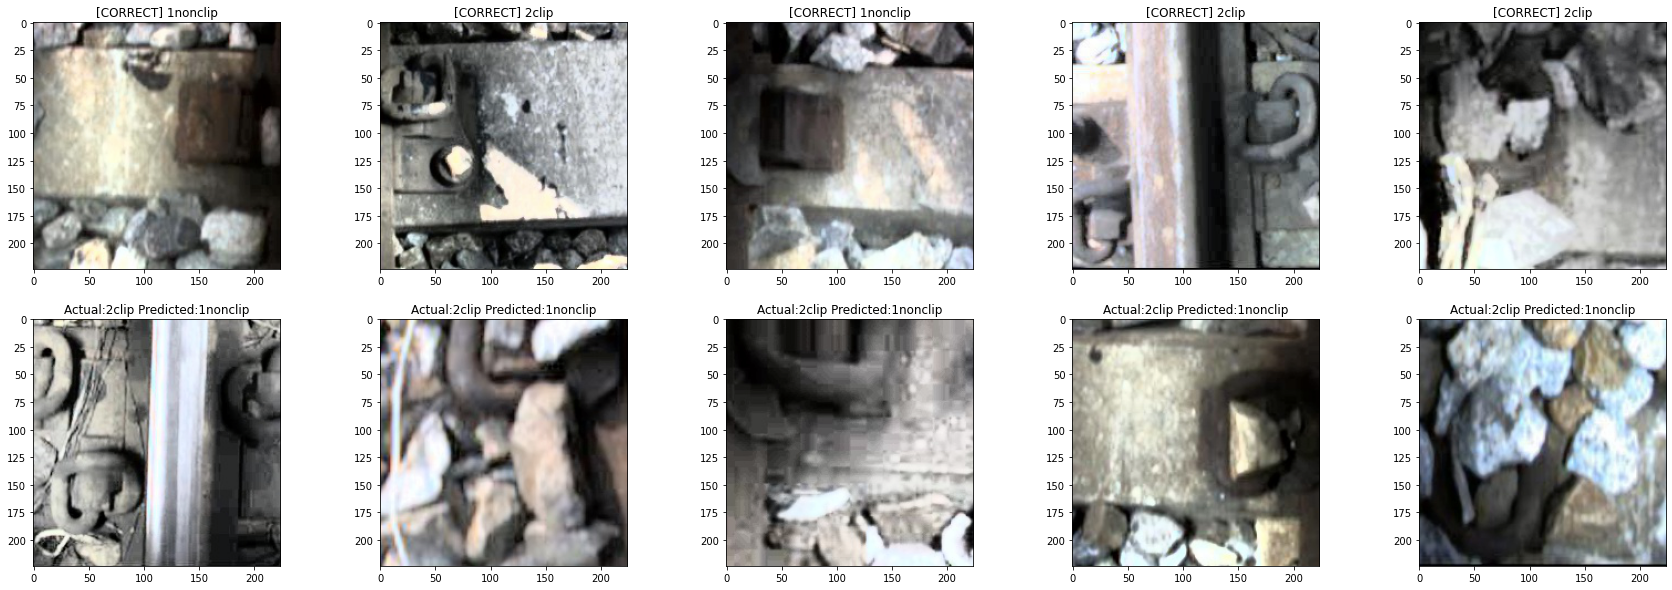

In [ ]:
showRandomSamples(allLabels,bestPredicted,fastenerTestDataset,sampleNum=5)

## 3.9 Transfer learning from pretrained model

Available pretrained models in PyTorch : https://pytorch.org/vision/stable/models.html

In [ ]:
pretrainNet = models.resnet34(pretrained=True)
# or you can use this
#num_ftrs = pretrainNet.fc.in_features
#pretrainNet.fc = nn.Linear(num_ftrs, 2)
# instead of figuring out the dimension from previous layer
pretrainNet.fc = nn.Linear(512, 2)
pretrainNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrainNet.parameters(), lr=0.001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=5, verbose=True)

fastenerTrainDatasetLoader = DataLoader(fastenerTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
fastenerTestDatasetLoader = DataLoader(fastenerTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


In [ ]:
bestAccuracy, bestPredicted, allLabels, bestNet = trainAndTestModel(fastenerTrainDatasetLoader, fastenerTestDatasetLoader,
                                                                    pretrainNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=10)

Overall Training Progress::   0%|          | 0/10 [00:00<?, ?it/s]

Epoch 1 / 10


/usr/local/lib/python3.7/dist-packages/torch/utils/data/dataloader.py:481: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  cpuset_checked))


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 2 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 3 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 4 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 5 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 6 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 7 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 8 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 9 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

Epoch 10 / 10


  0%|          | 0/71 [00:00<?, ?it/s]

  0%|          | 0/28 [00:00<?, ?it/s]

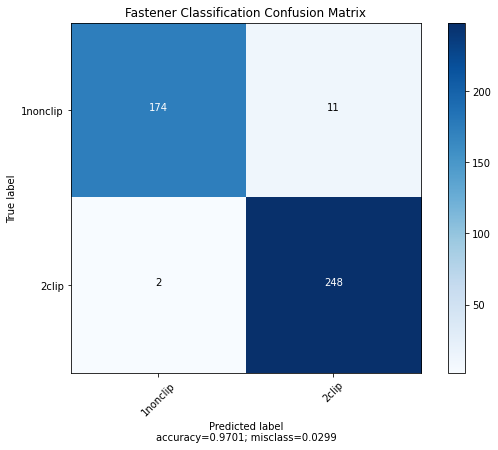

TP:174 TN:11 FP:2 FN:248


In [ ]:
confusionMatrix = confusion_matrix(allLabels, bestPredicted)
plot_confusion_matrix(cm           = confusionMatrix,
                      normalize    = False,
                      target_names = fastenerTrainDataset.classes,
                      title        = "Fastener Classification Confusion Matrix")
tn, fp, fn, tp = confusionMatrix.ravel()
print('TP:{} TN:{} FP:{} FN:{}'.format(tn, fp, fn, tp))

# 4.Exercise on dog breed classification.

In this exercise you will perform dog breed classification on images from https://www.kaggle.com/datasets/abhinavkrjha/dog-breed-classification

You goal is to use pytorch to read the dataset and train a CNN of your choice. Since the data is small, you should use transfer learning to get the best results.

The kaggle also comes with a Keras version of the task (https://www.kaggle.com/code/stpeteishii/dog-breed-classify-densenet201). You can use this as a reference for data loading. However, you should do this excercise using pytorch.

You might also look into data augmentation https://pytorch.org/docs/stable/torchvision/transforms.html to get the best results.

To easily download data from kaggle you should create a kaggle account. Generate an API key and upload it to colab.



In [ ]:
! pip install -q kaggle

In [ ]:
# Upload kaggle API key file
from google.colab import files
uploaded = files.upload()

!mkdir '/root/.kaggle'
!cp 'kaggle.json' '/root/.kaggle/.'
!chmod 600 '/root/.kaggle/kaggle.json'

Saving kaggle.json to kaggle.json


In [ ]:
!kaggle datasets download -d abhinavkrjha/dog-breed-classification

Dataset URL: https://www.kaggle.com/datasets/abhinavkrjha/dog-breed-classification
License(s): copyright-authors
 99% 111M/112M [00:00<00:00, 1.15GB/s]
100% 112M/112M [00:00<00:00, 1.13GB/s]


In [ ]:
!unzip dog-breed-classification.zip

Archive:  dog-breed-classification.zip
  inflating: Affenhuahua dog/Image_1.jpg  
  inflating: Affenhuahua dog/Image_10.jpg  
  inflating: Affenhuahua dog/Image_11.jpg  
  inflating: Affenhuahua dog/Image_12.jpg  
  inflating: Affenhuahua dog/Image_13.jpg  
  inflating: Affenhuahua dog/Image_14.jpg  
  inflating: Affenhuahua dog/Image_15.jpg  
  inflating: Affenhuahua dog/Image_16.jpg  
  inflating: Affenhuahua dog/Image_17.jpg  
  inflating: Affenhuahua dog/Image_18.jpg  
  inflating: Affenhuahua dog/Image_19.jpg  
  inflating: Affenhuahua dog/Image_2.jpg  
  inflating: Affenhuahua dog/Image_20.jpg  
  inflating: Affenhuahua dog/Image_21.png  
  inflating: Affenhuahua dog/Image_22.jpg  
  inflating: Affenhuahua dog/Image_23.jpg  
  inflating: Affenhuahua dog/Image_24.jpg  
  inflating: Affenhuahua dog/Image_25.jpg  
  inflating: Affenhuahua dog/Image_26.png  
  inflating: Affenhuahua dog/Image_27.jpg  
  inflating: Affenhuahua dog/Image_28.jpg  
  inflating: Affenhuahua dog/Image_29.j

In [ ]:
import random
import numpy as np
import cv2
from matplotlib import pyplot as plt
from tqdm.notebook import tqdm

import torch
import torch.nn.functional as F
import torch.nn as nn
import torch.optim as optim
from torch.utils.data import DataLoader
from torchvision.datasets import ImageFolder
from torchvision import transforms
from torchvision import models as models
from sklearn.metrics import confusion_matrix

# To guarantee reproducible results
torch.manual_seed(2)
torch.backends.cudnn.deterministic = True
torch.backends.cudnn.benchmark = False
np.random.seed(2)

In [ ]:
!nvidia-smi

Thu Nov 13 15:52:09 2025       
+-----------------------------------------------------------------------------------------+
| NVIDIA-SMI 550.54.15              Driver Version: 550.54.15      CUDA Version: 12.4     |
|-----------------------------------------+------------------------+----------------------+
| GPU  Name                 Persistence-M | Bus-Id          Disp.A | Volatile Uncorr. ECC |
| Fan  Temp   Perf          Pwr:Usage/Cap |           Memory-Usage | GPU-Util  Compute M. |
|                                         |                        |               MIG M. |
|=========================================+========================+======================|
|   0  Tesla T4                       Off |   00000000:00:04.0 Off |                    0 |
| N/A   51C    P8             10W /   70W |       0MiB /  15360MiB |      0%      Default |
|                                         |                        |                  N/A |
+-----------------------------------------+-----

In [ ]:
import os
import shutil

# Create a new directory for dog images if it doesn't exist
output_dir = 'dog_images'
if not os.path.exists(output_dir):
    os.makedirs(output_dir)

# List all items in the current directory
current_items = os.listdir('./')

# Identify and move only the breed directories
# A simple heuristic: folders with 'dog' in their name and not the zip file itself
for item in current_items:
    item_path = os.path.join('./', item)
    if os.path.isdir(item_path) and 'dog' in item.lower():
        try:
            shutil.move(item_path, os.path.join(output_dir, item))
            print(f"Moved: {item} to {output_dir}/")
        except shutil.Error as e:
            print(f"Could not move {item}: {e}")


Moved: Auggie dog to dog_images/
Moved: Alaskan Malamute dog to dog_images/
Moved: Beagle dog to dog_images/
Moved: Bocker dog to dog_images/
Moved: Afgan Hound dog to dog_images/
Moved: Boxer dog to dog_images/
Could not move dog_images: Cannot move a directory './dog_images' into itself 'dog_images/dog_images'.
Moved: Affenhuahua dog to dog_images/
Moved: Bichon Frise dog to dog_images/
Moved: Bugg dog to dog_images/
Moved: Akita dog to dog_images/
Moved: American Bulldog dog to dog_images/
Moved: Belgian Tervuren dog to dog_images/
Moved: Bulldog dog to dog_images/
Moved: Borzoi dog to dog_images/


In [ ]:
### Helper function to display image from dataset ###
def getImageFromDataset(dataset, idx):
  sampleImage, sampleLabel = dataset.__getitem__(idx)
  ### Revert transformation ###
  sampleImage = ((sampleImage.permute(1,2,0).numpy() * np.array([0.229, 0.224, 0.225])) + np.array([0.485, 0.456, 0.406]))*255
  sampleImage = sampleImage.astype(np.uint8)
  sampleClassName = dataset.classes[sampleLabel]
  return sampleImage, sampleClassName

Total dog breed images : 694
Dog breed classes : ['Affenhuahua dog', 'Afgan Hound dog', 'Akita dog', 'Alaskan Malamute dog', 'American Bulldog dog', 'Auggie dog', 'Beagle dog', 'Belgian Tervuren dog', 'Bichon Frise dog', 'Bocker dog', 'Borzoi dog', 'Boxer dog', 'Bugg dog', 'Bulldog dog']


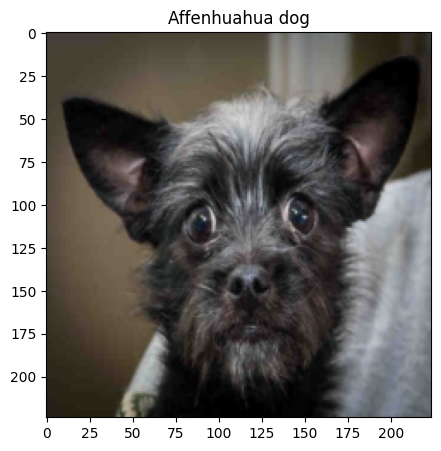

In [ ]:
transform = transforms.Compose([
    transforms.Resize((224,224)),
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

dogBreedDataset = ImageFolder('./dog_images', transform=transform)

print('Total dog breed images :', len(dogBreedDataset))
print('Dog breed classes :', dogBreedDataset.classes)

# Display a sample image
image, className = getImageFromDataset(dogBreedDataset, 0)
plt.figure(figsize=(5,5))
plt.imshow(image)
plt.title(className)
plt.show()

Displaying one sample image from each dog breed:


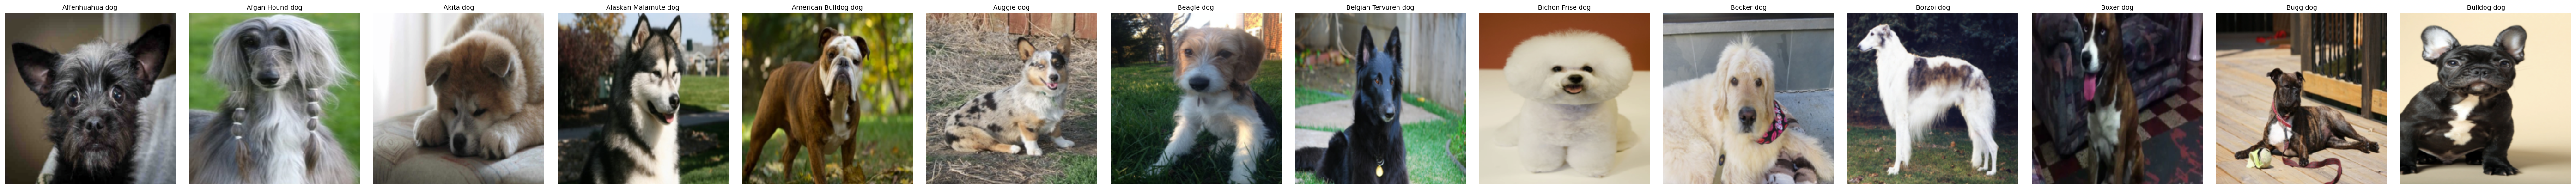

In [ ]:
num_classes = len(dogBreedDataset.classes)
# Adjust figure size based on the number of classes
fig, axes = plt.subplots(1, num_classes, figsize=(4 * num_classes, 4))

print("Displaying one sample image from each dog breed:")
for i, class_name in enumerate(dogBreedDataset.classes):
    # Find the first image belonging to this class in the dataset
    # dogBreedDataset.samples contains (image_path, class_idx) tuples
    image_idx_in_dataset = -1
    for ds_idx, (path, class_idx) in enumerate(dogBreedDataset.samples):
        if class_idx == i: # Check if the class index matches the current class
            image_idx_in_dataset = ds_idx
            break

    if image_idx_in_dataset != -1:
        image, _ = getImageFromDataset(dogBreedDataset, image_idx_in_dataset)
        # Ensure axes is iterable for a single subplot case
        if num_classes == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.imshow(image)
        ax.set_title(class_name, fontsize=10)
        ax.axis('off') # Hide axes for cleaner image display
    else:
        if num_classes == 1:
            ax = axes
        else:
            ax = axes[i]
        ax.set_title(f"No image for {class_name}", fontsize=10)
        ax.axis('off')

plt.tight_layout() # Adjust layout to prevent overlapping titles/images
plt.show()

In [ ]:
from torch.utils.data import random_split

# Define transforms for training with data augmentation
transform_train = transforms.Compose([
    transforms.RandomResizedCrop(224),  # Randomly crop and resize to 224x224
    transforms.RandomHorizontalFlip(),  # Randomly flip the image horizontally
    transforms.RandomRotation(15),     # Randomly rotate the image by up to 15 degrees
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Define transforms for testing (no augmentation, just resize and center crop)
transform_test = transforms.Compose([
    transforms.Resize(256),             # Resize to 256x256
    transforms.CenterCrop(224),         # Crop the center to 224x224
    transforms.ToTensor(),
    transforms.Normalize(mean=[0.485, 0.456, 0.406], std=[0.229, 0.224, 0.225])
])

# Apply the training transforms to the dataset for now, we will split and apply test transform later
dogBreedDataset.transform = transform_train

# Calculate sizes for training and testing sets (e.g., 80% train, 20% test)
train_size = int(0.8 * len(dogBreedDataset))
test_size = len(dogBreedDataset) - train_size

# Split the dataset
dogBreedTrainDataset, dogBreedTestDataset = random_split(dogBreedDataset, [train_size, test_size])

# Apply the test transform to the test subset
# Note: random_split gives subsets, we need to apply the transform specifically
# This workaround is needed because random_split doesn't copy dataset properties
class ImageFolderWithTransforms(ImageFolder):
    def __init__(self, root, transform=None):
        super().__init__(root, transform=transform)

# Re-create ImageFolder instances with appropriate transforms for train/test splits
# This is a bit clunky due to how random_split works with ImageFolder's transform attribute.
# A cleaner way would be to create two separate ImageFolder objects from the start.
# For now, let's just make sure the `dogBreedTestDataset` gets the test transform applied.
# Since `dogBreedDataset` is already loaded with `transform_train`, we need to apply `transform_test` specifically to the test portion.
# The `random_split` creates `Subset` objects, which don't directly support changing transforms.
# A better approach is to create two ImageFolder instances with different transforms and then split using indices, or ensure the initial ImageFolder handles the split.

# Let's re-evaluate: It's better to create two separate ImageFolder instances with the correct transforms
# if the data is already split into train/test folders.
# Since it's not, we'll use `random_split` but ensure the transforms are applied correctly.
# We can create custom Dataset classes that wrap the Subset and apply the correct transform.

class TransformedSubset(torch.utils.data.Dataset):
    def __init__(self, subset, transform=None):
        self.subset = subset
        self.transform = transform

    def __getitem__(self, index):
        x, y = self.subset[index]
        if self.transform:
            x = self.transform(x)
        return x, y

    def __len__(self):
        return len(self.subset)

# Apply the test transform to the test subset
dogBreedTrainDataset.dataset.transform = transform_train # Ensure original dataset has train transform for the train split
dogBreedTestDataset.dataset.transform = transform_test  # Ensure original dataset has test transform for the test split

# If ImageFolder doesn't re-read images based on transform change for subsets created by random_split,
# a more robust way is to re-initialize the ImageFolder for each split, but that requires separate folders.
# For a single folder, the above method of setting transform on `dataset` attribute of `Subset` should work if ImageFolder applies transform dynamically.

# Initialize DataLoaders
dogBreedTrainDatasetLoader = DataLoader(dogBreedTrainDataset, batch_size=16, shuffle=True, num_workers=4, pin_memory=True)
dogBreedTestDatasetLoader = DataLoader(dogBreedTestDataset, batch_size=16, shuffle=False, num_workers=4, pin_memory=True)

print('Total training images with augmentation:', len(dogBreedTrainDatasetLoader.dataset))
print('Total testing images:', len(dogBreedTestDatasetLoader.dataset))

Total training images with augmentation: 555
Total testing images: 139


/usr/local/lib/python3.12/dist-packages/torch/utils/data/dataloader.py:627: UserWarning: This DataLoader will create 4 worker processes in total. Our suggested max number of worker in current system is 2, which is smaller than what this DataLoader is going to create. Please be aware that excessive worker creation might get DataLoader running slow or even freeze, lower the worker number to avoid potential slowness/freeze if necessary.
  warnings.warn(


In [ ]:
### Train and test helper function ###
def testModel(testDatasetLoader, net):
  net.eval()
  correctImages = 0
  totalImages = 0
  allLabels = []
  allPredicted = []
  testingProgressbar = tqdm(enumerate(testDatasetLoader), total=len(testDatasetLoader))
  with torch.no_grad():
    for batchIdx, batchData in testingProgressbar:
      images, labels = batchData

      images, labels = images.cuda(), labels.cuda()
      outputs = net(images)
      _, predicted = torch.max(outputs, 1)

      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      testingProgressbar.set_description("Testing accuracy: {}".format(accumulateAccuracy ) )

      allLabels.append(labels)
      allPredicted.append(predicted)
  allLabels = torch.cat(allLabels).cpu().numpy()
  allPredicted = torch.cat(allPredicted).cpu().numpy()
  return correctImages, totalImages, allLabels, allPredicted

def trainAndTestModel(trainDatasetLoader, testDatasetLoader, net, optimizer,scheduler, criterion, trainEpoch):

  bestAccuracy = 0
  correctImages = 0
  totalImages = 0
  for currentEpoch in tqdm(range(trainEpoch), desc='Overall Training Progress:'):
    trainingLoss = 0.0
    net.train()
    print('Epoch',str(currentEpoch+1),'/',str(trainEpoch))
    trainingProgressbar = tqdm(enumerate(trainDatasetLoader), total=len(trainDatasetLoader))
    for batchIdx, batchData in trainingProgressbar:
      images, labels = batchData
      images, labels = images.cuda(), labels.cuda()

      # zero the parameter gradients
      optimizer.zero_grad()

      # forward + backward + optimize
      outputs = net(images)
      loss = criterion(outputs, labels)

      _, predicted = torch.max(outputs, 1)
      correctImages += (predicted == labels).sum().item()
      totalImages += labels.size(0)

      loss.backward()
      optimizer.step()


      trainingLoss += loss.item()
      accumulateAccuracy = round((correctImages/totalImages)*100,4)
      trainingProgressbar.set_description("Training accuracy: {} loss: {}".format(accumulateAccuracy, round(loss.item(),4) ) )
    scheduler.step(trainingLoss)
    correctImages, totalImages, allLabels, allPredicted = testModel(testDatasetLoader, net)
    testAccuracy = round((correctImages/totalImages)*100,2)

    print('='*10)

    if testAccuracy > bestAccuracy:
      bestAccuracy = testAccuracy
      bestPredicted = allPredicted
      bestNet = net

  return bestAccuracy, bestPredicted, allLabels, bestNet

In [ ]:
### Confusion matrix plot helper function from https://www.kaggle.com/grfiv4/plot-a-confusion-matrix ###
def plot_confusion_matrix(cm,target_names,title='Confusion matrix',cmap=None,normalize=True):
    import matplotlib.pyplot as plt
    import numpy as np
    import itertools

    accuracy = np.trace(cm) / float(np.sum(cm))
    misclass = 1 - accuracy

    if cmap is None:
        cmap = plt.get_cmap('Blues')

    plt.figure(figsize=(8, 6))
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()

    if target_names is not None:
        tick_marks = np.arange(len(target_names))
        plt.xticks(tick_marks, target_names, rotation=45)
        plt.yticks(tick_marks, target_names)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]


    thresh = cm.max() / 1.5 if normalize else cm.max() / 2
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        if normalize:
            plt.text(j, i, "{:0.4f}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")
        else:
            plt.text(j, i, "{:,}".format(cm[i, j]),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label\naccuracy={:0.4f}; misclass={:0.4f}'.format(accuracy, misclass))
    plt.show()

In [ ]:
pretrainNet = models.resnet50(weights=models.ResNet50_Weights.DEFAULT)
num_ftrs = pretrainNet.fc.in_features
# Modify the final fully connected layer to include a Dropout layer
pretrainNet.fc = nn.Sequential(
    nn.Dropout(0.5), # Add dropout layer
    nn.Linear(num_ftrs, num_classes)
)
pretrainNet.cuda()

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(pretrainNet.parameters(), lr=0.0001)
scheduler = optim.lr_scheduler.ReduceLROnPlateau(optimizer, patience=3)

Downloading: "https://download.pytorch.org/models/resnet50-11ad3fa6.pth" to /root/.cache/torch/hub/checkpoints/resnet50-11ad3fa6.pth


100%|██████████| 97.8M/97.8M [00:01<00:00, 75.1MB/s]


In [ ]:
bestAccuracy_dog, bestPredicted_dog, allLabels_dog, bestNet_dog = trainAndTestModel(dogBreedTrainDatasetLoader, dogBreedTestDatasetLoader,
                                                                    pretrainNet,
                                                                    optimizer, scheduler, criterion,
                                                                    trainEpoch=15)

Overall Training Progress::   0%|          | 0/15 [00:00<?, ?it/s]

Epoch 1 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 2 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 3 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 4 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 5 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 6 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 7 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 8 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 9 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 10 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 11 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 12 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 13 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 14 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

Epoch 15 / 15


  0%|          | 0/35 [00:00<?, ?it/s]

  0%|          | 0/9 [00:00<?, ?it/s]

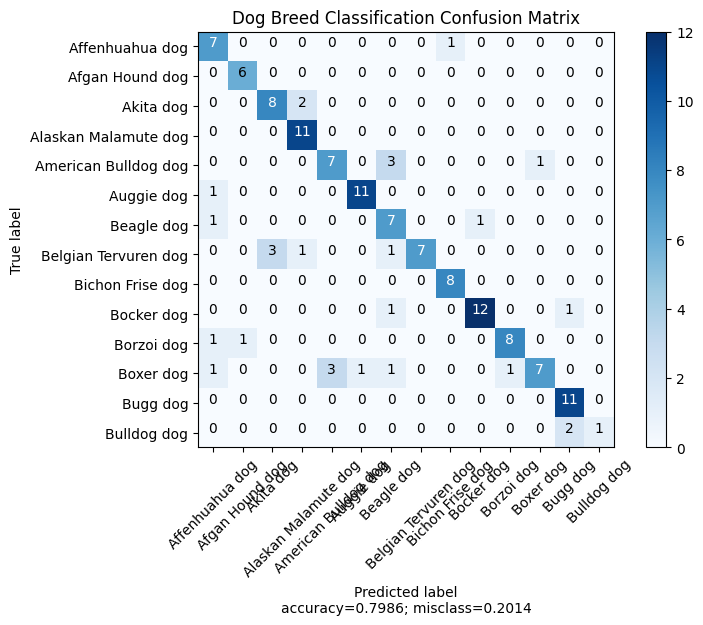


--- Per-Class TP, TN, FP, FN ---
Class: Affenhuahua dog
  TP: 7, TN: 127, FP: 4, FN: 1
Class: Afgan Hound dog
  TP: 6, TN: 132, FP: 1, FN: 0
Class: Akita dog
  TP: 8, TN: 126, FP: 3, FN: 2
Class: Alaskan Malamute dog
  TP: 11, TN: 125, FP: 3, FN: 0
Class: American Bulldog dog
  TP: 7, TN: 125, FP: 3, FN: 4
Class: Auggie dog
  TP: 11, TN: 126, FP: 1, FN: 1
Class: Beagle dog
  TP: 7, TN: 124, FP: 6, FN: 2
Class: Belgian Tervuren dog
  TP: 7, TN: 127, FP: 0, FN: 5
Class: Bichon Frise dog
  TP: 8, TN: 130, FP: 1, FN: 0
Class: Bocker dog
  TP: 12, TN: 124, FP: 1, FN: 2
Class: Borzoi dog
  TP: 8, TN: 128, FP: 1, FN: 2
Class: Boxer dog
  TP: 7, TN: 124, FP: 1, FN: 7
Class: Bugg dog
  TP: 11, TN: 125, FP: 3, FN: 0
Class: Bulldog dog
  TP: 1, TN: 136, FP: 0, FN: 2


In [ ]:
confusionMatrix_dog = confusion_matrix(allLabels_dog, bestPredicted_dog)
plot_confusion_matrix(cm           = confusionMatrix_dog,
                      normalize    = False,
                      target_names = dogBreedDataset.classes,
                      title        = "Dog Breed Classification Confusion Matrix")

num_classes = confusionMatrix_dog.shape[0]

# Calculate TP, TN, FP, FN for each class
tp_per_class = np.diag(confusionMatrix_dog)
fp_per_class = np.sum(confusionMatrix_dog, axis=0) - tp_per_class
fn_per_class = np.sum(confusionMatrix_dog, axis=1) - tp_per_class
tn_per_class = []

for i in range(num_classes):
    # TN for class i: sum of all elements except those in row i and column i
    temp_tn = np.sum(confusionMatrix_dog) - (tp_per_class[i] + fp_per_class[i] + fn_per_class[i])
    tn_per_class.append(temp_tn)

print("\n--- Per-Class TP, TN, FP, FN ---")
for i, class_name in enumerate(dogBreedDataset.classes):
    print(f"Class: {class_name}")
    print(f"  TP: {tp_per_class[i]}, TN: {tn_per_class[i]}, FP: {fp_per_class[i]}, FN: {fn_per_class[i]}")
